In [1]:
import pandas as pd
import scanpy as sc
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="tqdm")


adata = sc.read_10x_mtx(
    "/home/orion1016/filtered_gene_bc_matrices/hg19/",
    var_names="gene_symbols",
    cache=True,
)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)


In [2]:
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

In [3]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()
sc.pp.normalize_total(adata, target_sum=1e4)

In [4]:
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [5]:
adata = adata[:, adata.var.highly_variable]
adata.shape

(2638, 1838)

In [6]:
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])

/home/orion1016/anaconda3/envs/rapids-24.06/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:657: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [7]:
sc.pp.scale(adata, max_value=10)

In [8]:
sc.tl.pca(adata, svd_solver="arpack")

In [9]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

/home/orion1016/anaconda3/envs/rapids-24.06/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
sc.tl.leiden(
    adata,
    resolution=0.9,
    random_state=0,
    flavor="igraph",
    n_iterations=2,
    directed=False,
)
new_cluster_names = [
    "CD4 T",
    "B",
    "FCGR3A+ Monocytes",
    "NK",
    "CD8 T",
    "CD14+ Monocytes",
    "Dendritic",
    "Megakaryocytes",
]
adata.rename_categories("leiden", new_cluster_names)

In [11]:
adata.obs['Cell_type'] = adata.obs['leiden']

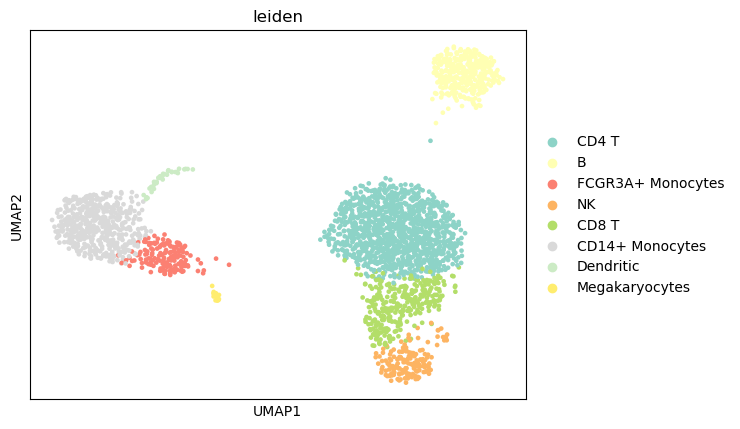

In [12]:
sc.tl.umap(adata)
sc.pl.umap(adata, color='leiden', palette='Set3')

In [13]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
from scipy.stats import mode
import scanpy as sc
import sklearn
import warnings
import anndata

sys.path.insert(0, "../")
import scgpt as scg

# extra dependency for similarity search
try:
    import faiss

    faiss_imported = True
except ImportError:
    faiss_imported = False
    print(
        "faiss not installed! We highly recommend installing it for fast similarity search."
    )
    print("To install it, see https://github.com/facebookresearch/faiss/wiki/Installing-Faiss")

warnings.filterwarnings("ignore", category=ResourceWarning)

/home/orion1016/scGPT/tutorials/../scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/home/orion1016/scGPT/tutorials/../scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")


In [14]:
model_dir = Path("/home/orion1016/save/scGPT_human/")
gene_col = "index"

In [15]:
test_adata = adata
embed_adata = scg.tasks.cell_emb.embed_data(
    test_adata,
    model_dir,
    gene_col=gene_col,
    batch_size=64,
    return_new_adata=True
)

scGPT - INFO - match 1693/1838 genes in vocabulary of size 60697.


/home/orion1016/scGPT/tutorials/../scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|██████████████████████████| 42/42 [00:09<00:00,  4.33it/s]
/home/orion1016/anaconda3/envs/rapids-24.06/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [16]:
from build_atlas_index_faiss import load_index, vote, weighted_vote

In [17]:
use_gpu = faiss.get_num_gpus() > 0
index, meta_labels = load_index(
    index_dir="/home/orion1016/save/faiss_index/", 
    use_config_file=False,
    use_gpu=use_gpu,
)
print(f"Loaded index with {index.ntotal} cells")

Loading index and meta from /home/orion1016/save/faiss_index/ ...
Index loaded, num_embeddings: 35096827
Set nprobe from 128 to 128 for 16384 clusters
Loaded index with 35096827 cells


In [18]:
embed = embed_adata.X

In [19]:
k = 50
distances, idx = index.search(embed, k)

In [20]:
predict_labels = meta_labels[idx]
from tqdm import tqdm

voting = []
for preds in tqdm(predict_labels):
    labels, probs = vote(preds, return_prob=True)
    if probs[0] >= 0.1:
        voting.append(labels[0])
    else:
        voting.append('indeterminate')

voting = np.array(voting)


100%|████████████████████████████████████| 2638/2638 [00:00<00:00, 55899.47it/s]


In [21]:
# Add the predicted labels to the AnnData object
adata.obs['cell_type'] = voting

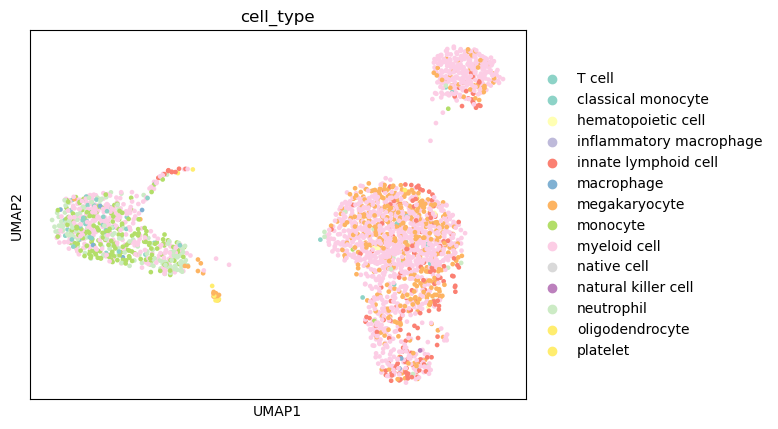

In [22]:
sc.tl.umap(adata)
sc.pl.umap(adata, color='cell_type', palette='Set3')

In [23]:
from sklearn.model_selection import train_test_split

train_indices, test_indices = train_test_split(range(adata.n_obs), test_size=0.2, random_state=42)
adata_train = adata[train_indices].copy()
adata_test = adata[test_indices].copy()

print(f"Taille de l'ensemble d'entraînement: {adata_train.shape}")
print(f"Taille de l'ensemble de test: {adata_test.shape}")

Taille de l'ensemble d'entraînement: (2110, 1838)
Taille de l'ensemble de test: (528, 1838)


In [24]:
ref_embed_adata = scg.tasks.cell_emb.embed_data(
    adata_train,
    model_dir,
    gene_col=gene_col,
    batch_size=64,
    return_new_adata=False
)

scGPT - INFO - match 1693/1838 genes in vocabulary of size 60697.


/home/orion1016/scGPT/tutorials/../scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|██████████████████████████| 33/33 [00:10<00:00,  3.04it/s]
/home/orion1016/scGPT/tutorials/../scgpt/tasks/cell_emb.py:279: ImplicitModificationWarning: Setting element `.obsm['X_scGPT']` of view, initializing view as actual.
  adata.obsm["X_scGPT"] = cell_embeddings


In [25]:
test_embed_adata = scg.tasks.cell_emb.embed_data(
    adata_test,
    model_dir,
    gene_col=gene_col,
    batch_size=64,
    return_new_adata=False
)

scGPT - INFO - match 1693/1838 genes in vocabulary of size 60697.


Embedding cells: 100%|████████████████████████████| 9/9 [00:06<00:00,  1.45it/s]


In [26]:
cell_type_key = "cell_type"

# concatenate the two datasets
adata_concat = anndata.concat([test_embed_adata, ref_embed_adata], join='outer', label="dataset")
adata_concat.obs["is_ref"] = ["Query"] * len(test_embed_adata) + ["Reference"] * len(ref_embed_adata)
adata_concat.obs["is_ref"] = adata_concat.obs["is_ref"].astype("category")

# mask the query dataset cell types
adata_concat.obs[cell_type_key] = adata_concat.obs[cell_type_key].astype("category")
adata_concat.obs[cell_type_key] = adata_concat.obs[cell_type_key].cat.add_categories(["To be predicted"])
adata_concat.obs.iloc[:len(test_embed_adata), adata_concat.obs.columns.get_loc(cell_type_key)] = "To be predicted"

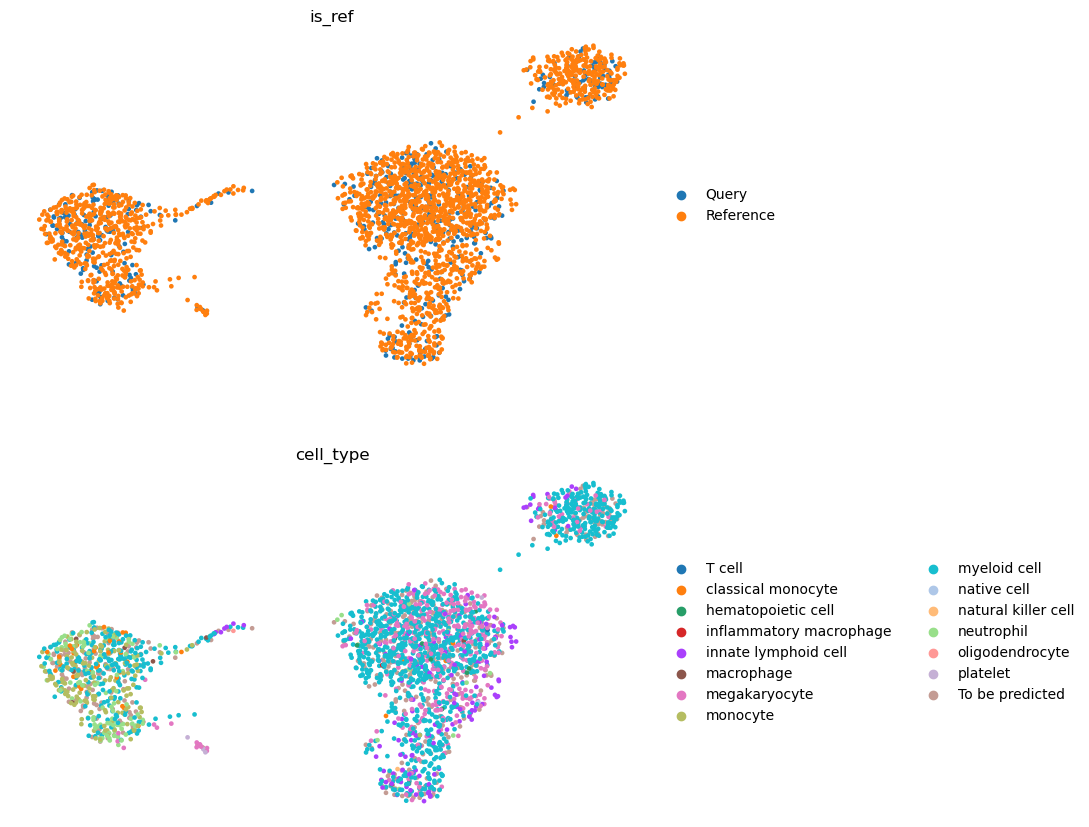

In [27]:
sc.pp.neighbors(adata_concat, n_neighbors=10, n_pcs=40)
sc.tl.leiden(
    adata_concat,
    resolution=0.9,
    random_state=0,
    flavor="igraph",
    n_iterations=2,
    directed=False,
)
sc.tl.umap(adata_concat)
sc.pl.umap(
    adata_concat, color=["is_ref", cell_type_key], wspace=0.4, frameon=False, ncols=1, save = True
)

In [28]:
ref_cell_embeddings = ref_embed_adata.obsm["X_scGPT"]
test_embed = test_embed_adata.obsm["X_scGPT"]

k = 15  # number of neighbors


Index = faiss.IndexFlatL2(ref_cell_embeddings.shape[1])
Index.add(ref_cell_embeddings)

# Query dataset, k - number of closest elements (returns 2 numpy arrays)
distances, labels = Index.search(test_embed, k)

idx_list=[i for i in range(test_embed.shape[0])]
preds = []
sim_list = distances
for k in idx_list:
    if faiss_imported:
        idx = labels[k]
    else:
        idx, sim = get_similar_vectors(test_embed[k][np.newaxis, ...], ref_cell_embeddings, k)
    pred = ref_embed_adata.obs[cell_type_key].iloc[idx].value_counts()
    preds.append(pred.index[0])
gt = adata_test.obs[cell_type_key].to_numpy()

sklearn.metrics.accuracy_score(gt, preds)

0.6761363636363636

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

res_dict = {
    "accuracy": accuracy_score(gt, preds),
    "precision": precision_score(gt, preds, average="macro", zero_division = 1),
    "recall": recall_score(gt, preds, average="macro"),
    "macro_f1": f1_score(gt, preds, average="macro"),
}

res_dict

{'accuracy': 0.6761363636363636,
 'precision': 0.7793593950118092,
 'recall': 0.2413321954962822,
 'macro_f1': 0.2675236876993329}

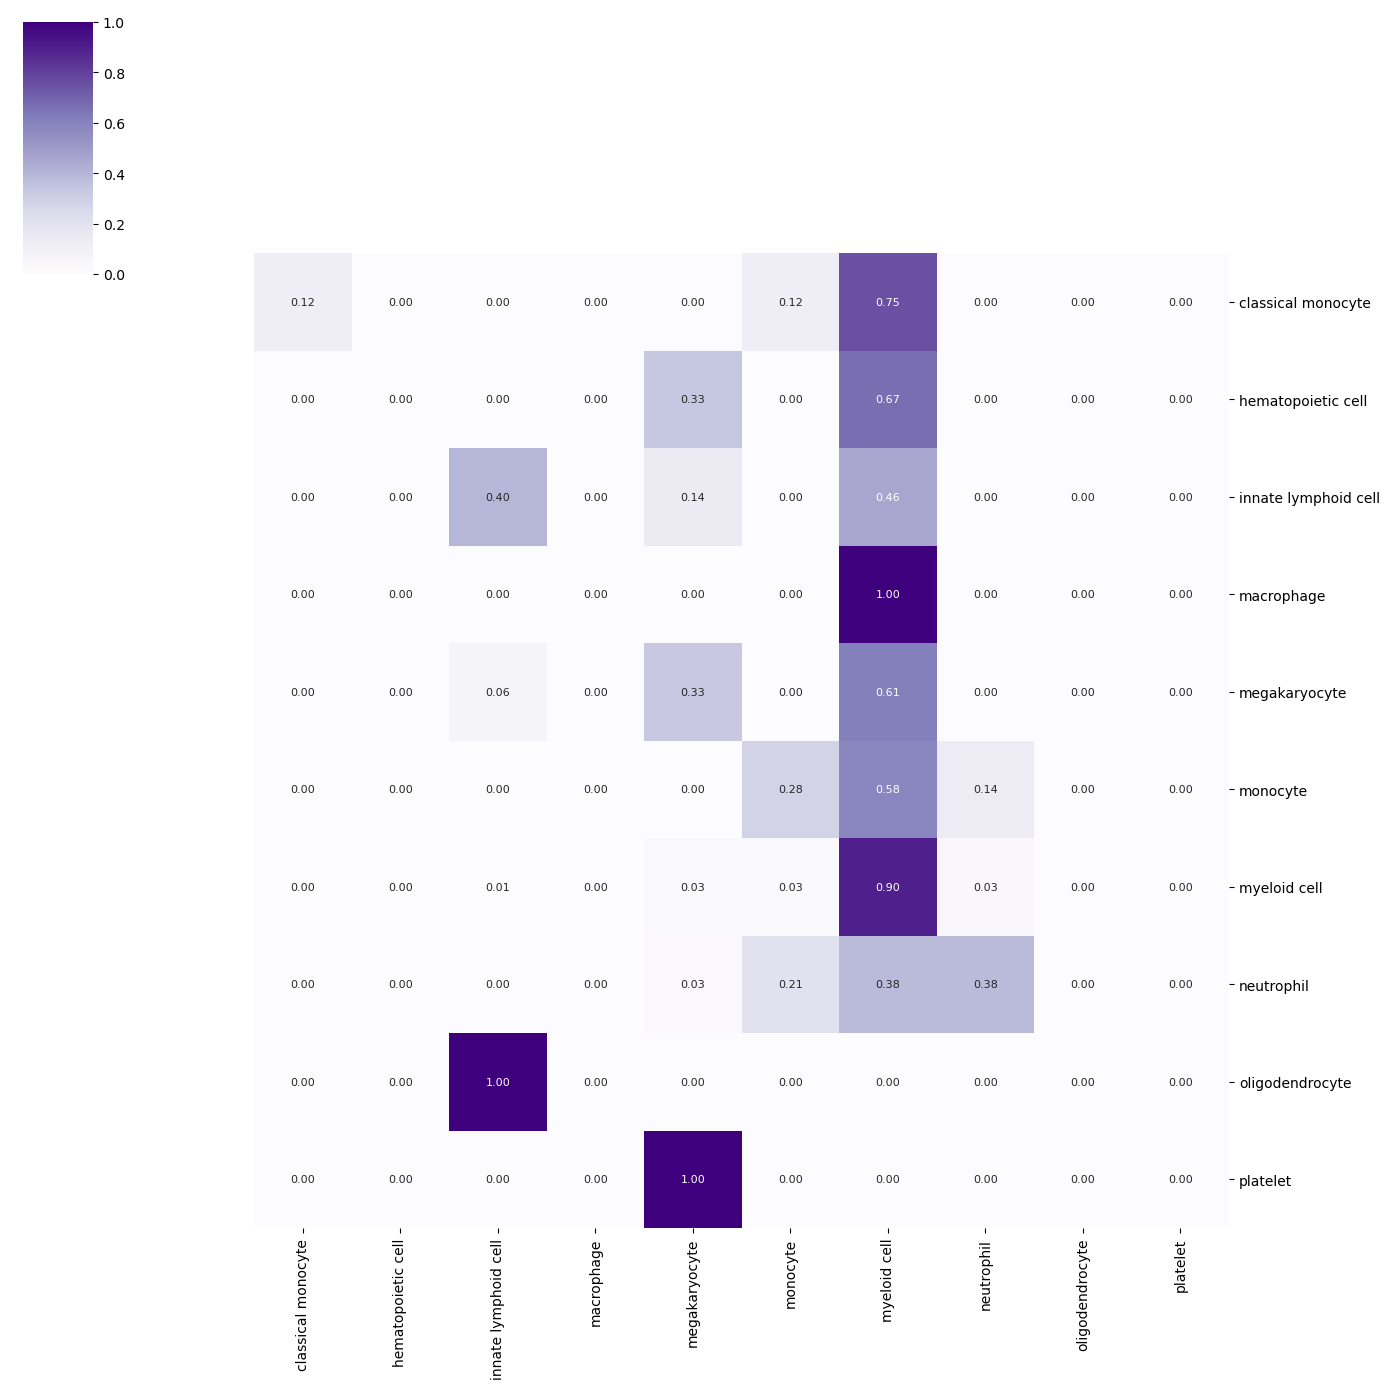

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = gt
y_pred = preds
cell_type_list = np.unique(y_true)
matrix = confusion_matrix(y_true, y_pred, labels=cell_type_list)
matrix = matrix.astype("float") / matrix.sum(axis=1)[:, np.newaxis]

df = pd.DataFrame(matrix, index=cell_type_list[:matrix.shape[0]], columns=cell_type_list[:matrix.shape[1]])

ax = sns.clustermap(df,  
                    cmap='Purples',
                    annot=True ,fmt=".2f", 
                    annot_kws={'size': 8}, 
                    vmin=0, 
                    vmax=1,
                    row_cluster=False, 
                    col_cluster=False, 
                    figsize=(14, 14))

ax.savefig('confusion_matrix.png')


/tmp/ipykernel_88681/1718928671.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percentages = data.groupby('cluster')['predicted_cell_type'].value_counts(normalize=True).unstack().fillna(0) * 100


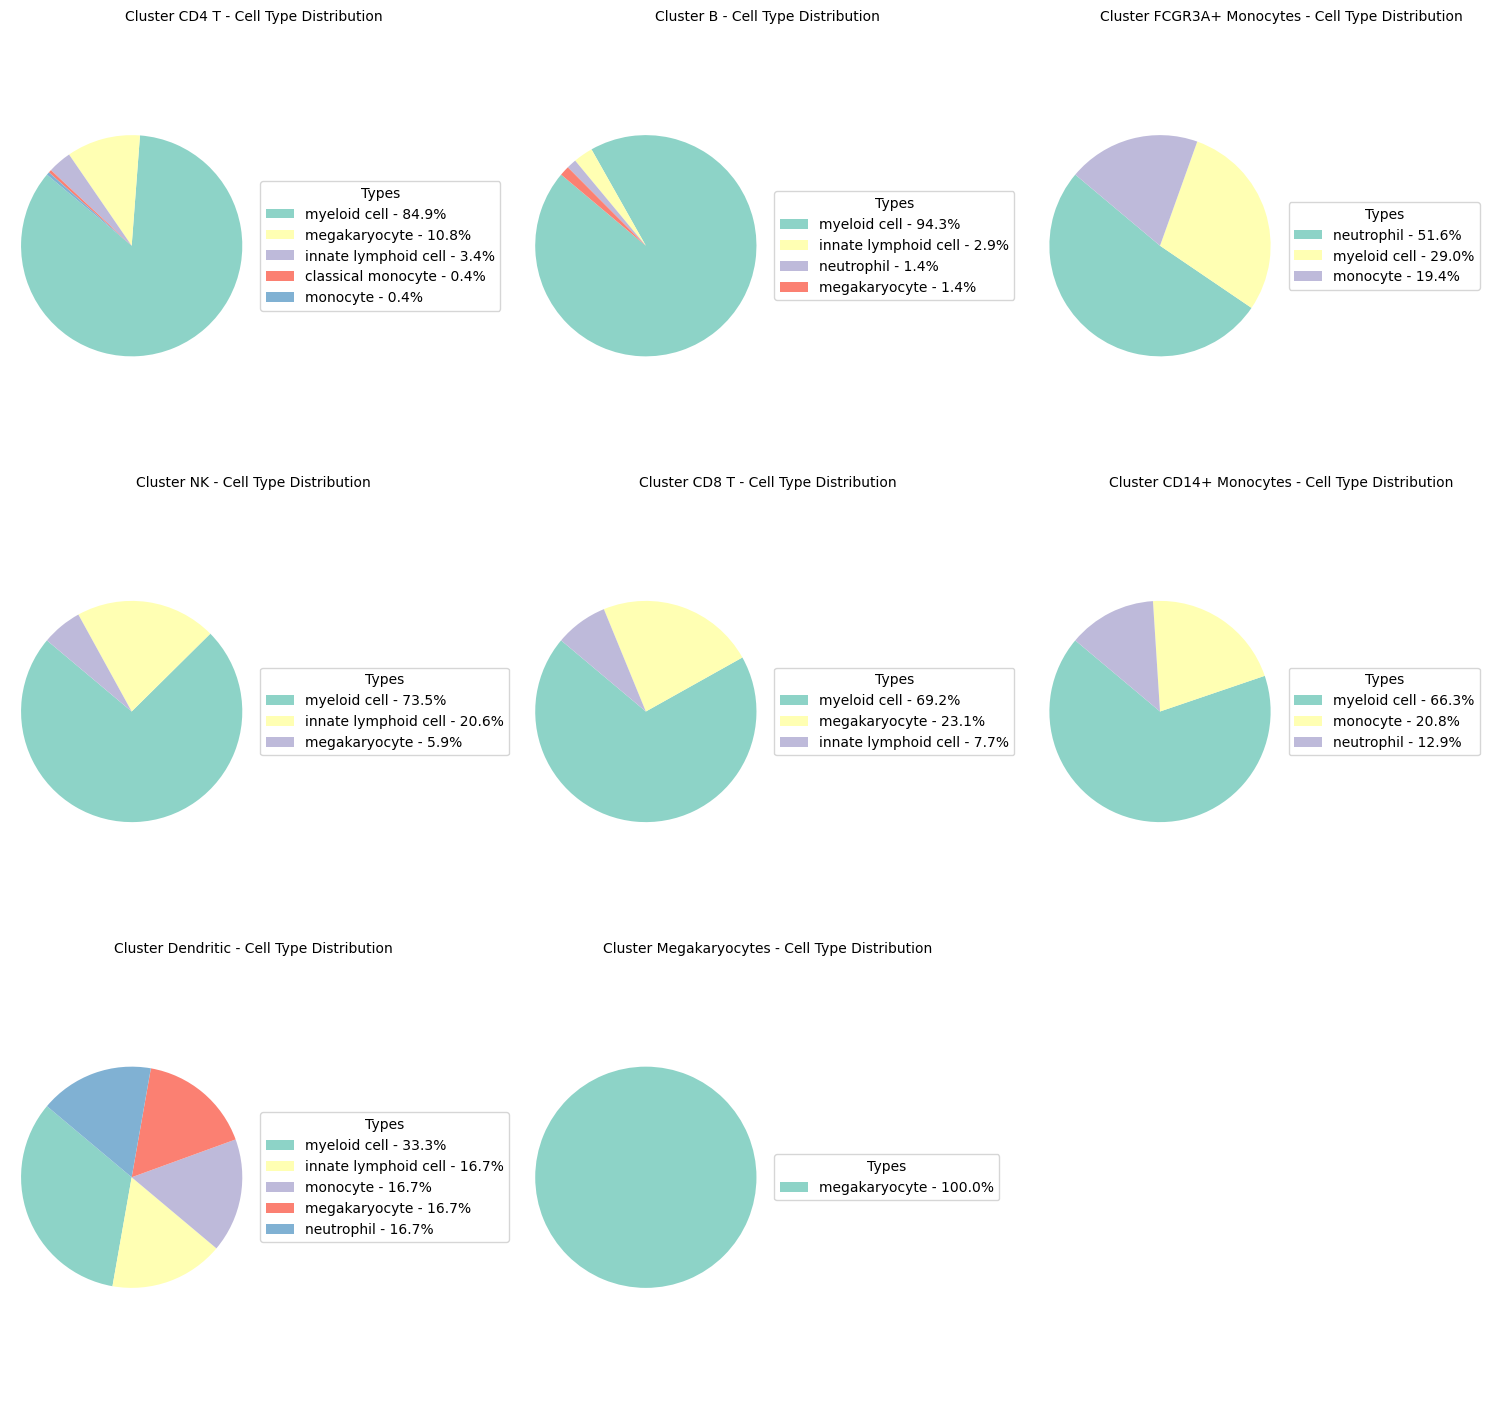

In [32]:
import matplotlib.pyplot as plt
import pandas as pd

# Supposons que vous ayez les clusters dans votre objet AnnData
clusters = test_embed_adata.obs['leiden']  # Remplacez 'leiden' par le nom de votre colonne de clusters

# Combiner les clusters et les prédictions dans un DataFrame
data = pd.DataFrame({'cluster': clusters, 'predicted_cell_type': preds})

# Calculer la distribution des types cellulaires prédits par cluster
percentages = data.groupby('cluster')['predicted_cell_type'].value_counts(normalize=True).unstack().fillna(0) * 100

def plot_cluster_pie_chart(cluster_id, ax):
    values = percentages.loc[cluster_id]
    
    # Trier les types cellulaires par pourcentage décroissant
    sorted_values = values.sort_values(ascending=False)
    
    # Filtrer les valeurs non nulles
    nonzero_values = sorted_values[sorted_values > 0]
    
    # Tracer le pie chart
    wedges, texts = ax.pie(nonzero_values, labels=None, startangle=140, labeldistance=1.1, colors=plt.cm.Set3.colors)
    ax.axis('equal')  # Assurer que le pie chart est un cercle
    
    # Ajouter des labels avec les pourcentages
    total = nonzero_values.sum()
    labels = [f'{t} - {v:.1f}%' for t, v in zip(nonzero_values.index, nonzero_values)]
    
    if len(nonzero_values) > 0:
        ax.legend(wedges, labels, title="Types", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    
    ax.set_title(f'Cluster {cluster_id} - Cell Type Distribution', fontsize=10, loc='center', x= 1)

# Calcul du nombre de subplots nécessaires
num_clusters = len(percentages.index)
num_plots = min(num_clusters, 9)  # On affiche au maximum 9 plots dans une grille 3x3

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)

# Boucle sur les index des clusters pour générer les plots
for i, cluster_id in enumerate(percentages.index[:num_plots]):
    row_index = i // 3
    col_index = i % 3
    plot_cluster_pie_chart(cluster_id, axs[row_index, col_index])
    
# Désactiver les axes vides si le nombre de clusters est inférieur à 9
if num_plots < 9:
    for j in range(num_plots, 9):
        fig.delaxes(axs.flatten()[j])

# Ajustement des espacements et enregistrement des figures
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.savefig('cluster_pie_charts_scGPT_pred_annot.png')

plt.show()


In [ ]:
# rajouter peut etre une partie en montrant avec un indice de confiance plus élevé 

In [ ]:
adata_filtered = adata[adata.obs['cell_type'] != 'indeterminate']
sc.pl.umap(adata_filtered, color='cell_type')

In [ ]:
len(adata_filtered)

In [ ]:
import pandas as pd
from collections import defaultdict

df = adata.obs[['cell_type', 'leiden']].copy()

# Count occurrences of each cell type within each cluster
counts = df.groupby(['leiden', 'cell_type'], observed=True).size().unstack(fill_value=0)
percentages = counts.apply(lambda x: x / x.sum(), axis=1)

In [ ]:
import matplotlib.pyplot as plt

def plot_cluster_pie_chart(cluster_id, ax):
    types = percentages.columns
    values = percentages.loc[cluster_id]
    
    sorted_indices = values.argsort()[::-1]
    sorted_values = values.iloc[sorted_indices]
    sorted_types = types[sorted_indices]
    
    nonzero_values = sorted_values[sorted_values > 0]
    nonzero_types = sorted_types[sorted_values > 0]
    
    wedges, texts = ax.pie(nonzero_values, labels=None, startangle=140, labeldistance=1.1, colors=plt.cm.Set3.colors)
    
    ax.axis('equal')  
    
    total = sum(nonzero_values)
    labels = [f'{t} - {v / total * 100:.1f}%' for t, v in zip(nonzero_types, nonzero_values)]
    
    if len(nonzero_values) > 0:
        ax.legend(wedges, labels, title="Types", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    
    ax.set_title(f'Cluster {cluster_id} - Cell Type Distribution', fontsize=10, loc='center', x=2)  # Centrer le titre

# Calcul du nombre de subplots nécessaires
num_clusters = len(percentages.index)
num_plots = min(num_clusters, 8)  # On affiche au maximum 9 plots dans une grille 3x3

fig, axs = plt.subplots(3, 3, figsize=(12, 12))
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)
# Boucle sur les index des clusters pour générer les plots
for i, cluster_id in enumerate(percentages.index[:num_plots]):
    row_index = i // 3  
    col_index = i % 3  
    plot_cluster_pie_chart(cluster_id, axs[row_index, col_index])
    
um_plots = 8
if num_plots < 9:
    axs[2, 2].axis('off')
    
# Ajustement des espacements et enregistrement des figures
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.savefig('cluster_pie_charts.png')
plt.show()


In [ ]:
import anndata
from sklearn.model_selection import train_test_split

# Séparer en ensembles d'entraînement et de test
train_indices, test_indices = train_test_split(range(adata.n_obs), test_size=0.2, random_state=42)
adata_train = adata[train_indices].copy()
adata_test = adata[test_indices].copy()

print(f"Taille de l'ensemble d'entraînement: {adata_train.shape}")
print(f"Taille de l'ensemble de test: {adata_test.shape}")

# Embed data (fonctionnalité spécifique, remplacer selon le contexte)
ref_embed_adata = scg.tasks.cell_emb.embed_data(
    adata_train,
    model_dir,
    gene_col=gene_col,
    batch_size=64,
    return_new_adata=False
)
test_embed_adata = scg.tasks.cell_emb.embed_data(
    adata_test,
    model_dir,
    gene_col=gene_col,
    batch_size=64,
    return_new_adata=False
)

# Concatenate les deux ensembles de données
adata_concat = anndata.concat([test_embed_adata, ref_embed_adata], join='outer', label="dataset")
adata_concat.obs["is_ref"] = ["Query"] * len(test_embed_adata) + ["Reference"] * len(ref_embed_adata)
adata_concat.obs["is_ref"] = adata_concat.obs["is_ref"].astype("category")

# Ajouter une colonne cell_type pour les annotations
adata_concat.obs['Cell_type'] = adata_concat.obs['leiden']

# Masquer les types de cellules de l'ensemble de test
adata_concat.obs['Cell_type'] = adata_concat.obs['Cell_type'].astype("category")
adata_concat.obs['Cell_type'] = adata_concat.obs['Cell_type'].cat.add_categories(["To be predicted"])
adata_concat.obs.iloc[:len(test_embed_adata), adata_concat.obs.columns.get_loc('Cell_type')] = "To be predicted"

# Calculer les voisins et les clusters
sc.pp.neighbors(adata_concat, n_neighbors=10, n_pcs=40)
sc.tl.leiden(
    adata_concat,
    resolution=0.9,
    random_state=0,
    flavor="igraph",
    n_iterations=2,
    directed=False,
)
sc.tl.umap(adata_concat)

# Afficher les résultats après concaténation
sc.pl.umap(
    adata_concat, 
    color=["is_ref", "Cell_type"], 
    wspace=0.4, 
    frameon=False, 
    ncols=1,
    title=["Référence vs Query", "Clusters après concaténation"]
)


In [ ]:
ref_cell_embeddings = ref_embed_adata.obsm["X_scGPT"]
test_embed = test_embed_adata.obsm["X_scGPT"]

k = 15  # number of neighbors

Index = faiss.IndexFlatL2(ref_cell_embeddings.shape[1])
Index.add(ref_cell_embeddings)

distances, labels = Index.search(test_embed, k)

idx_list=[i for i in range(test_embed.shape[0])]
predictions = []
sim_list = distances
for k in idx_list:
    if faiss_imported:
        idx = labels[k]
    else:
        idx, sim = get_similar_vectors(test_embed[k][np.newaxis, ...], ref_cell_embeddings, k)
    pred = ref_embed_adata.obs['Cell_type'].iloc[idx].value_counts()
    predictions.append(pred.index[0])
gt = adata_test.obs['Cell_type'].to_numpy()

sklearn.metrics.accuracy_score(gt, predictions)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

res_dict = {
    "accuracy": accuracy_score(gt, predictions),
    "precision": precision_score(gt, predictions, average="macro", zero_division = 1),
    "recall": recall_score(gt, predictions, average="macro"),
    "macro_f1": f1_score(gt, predictions, average="macro"),
}

res_dict

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = gt
y_pred = predictions
cell_type_list = np.unique(y_true)
matrix = confusion_matrix(y_true, y_pred, labels=cell_type_list)
matrix = matrix.astype("float") / matrix.sum(axis=1)[:, np.newaxis]

df = pd.DataFrame(matrix, index=cell_type_list[:matrix.shape[0]], columns=cell_type_list[:matrix.shape[1]])

ax = sns.clustermap(df,  
                    cmap='Purples',
                    annot=True ,fmt=".2f", 
                    annot_kws={'size': 8}, 
                    vmin=0, 
                    vmax=1,
                    row_cluster=False, 
                    col_cluster=False, 
                    figsize=(14, 14))

ax.savefig('confusion_matrix_annote.png')


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Supposons que vous ayez les clusters dans votre objet AnnData
clusters = test_embed_adata.obs['leiden']  # Remplacez 'leiden' par le nom de votre colonne de clusters

# Combiner les clusters et les prédictions dans un DataFrame
data = pd.DataFrame({'cluster': clusters, 'predicted_cell_type': predictions})

# Calculer la distribution des types cellulaires prédits par cluster
percentages = data.groupby('cluster')['predicted_cell_type'].value_counts(normalize=True).unstack().fillna(0) * 100

def plot_cluster_pie_chart(cluster_id, ax):
    values = percentages.loc[cluster_id]
    
    # Trier les types cellulaires par pourcentage décroissant
    sorted_values = values.sort_values(ascending=False)
    
    # Filtrer les valeurs non nulles
    nonzero_values = sorted_values[sorted_values > 0]
    
    # Tracer le pie chart
    wedges, texts = ax.pie(nonzero_values, labels=None, startangle=140, labeldistance=1.1, colors=plt.cm.Set3.colors)
    ax.axis('equal')  # Assurer que le pie chart est un cercle
    
    # Ajouter des labels avec les pourcentages
    total = nonzero_values.sum()
    labels = [f'{t} - {v:.1f}%' for t, v in zip(nonzero_values.index, nonzero_values)]
    
    if len(nonzero_values) > 0:
        ax.legend(wedges, labels, title="Types", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    
    ax.set_title(f'Cluster {cluster_id} - Cell Type Distribution', fontsize=10, loc='center', x= 1)

# Calcul du nombre de subplots nécessaires
num_clusters = len(percentages.index)
num_plots = min(num_clusters, 9)  # On affiche au maximum 9 plots dans une grille 3x3

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)

# Boucle sur les index des clusters pour générer les plots
for i, cluster_id in enumerate(percentages.index[:num_plots]):
    row_index = i // 3
    col_index = i % 3
    plot_cluster_pie_chart(cluster_id, axs[row_index, col_index])
    
# Désactiver les axes vides si le nombre de clusters est inférieur à 9
if num_plots < 9:
    for j in range(num_plots, 9):
        fig.delaxes(axs.flatten()[j])

# Ajustement des espacements et enregistrement des figures
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.savefig('cluster_pie_charts_good_annot.png')

plt.show()


In [ ]:
predict_labels = meta_labels[idx]
# from scipy.stats import mode
from tqdm import tqdm

voting = []
for preds in tqdm(predict_labels):
    voting.append(vote(preds, return_prob=False)[0])
voting = np.array(voting)

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

vote_counts = Counter(voting)

labels = list(vote_counts.keys())
sizes = list(vote_counts.values())

total = sum(sizes)
percentages = [(size / total) * 100 for size in sizes]

plt.figure(figsize=(8, 8))
wedges, texts = plt.pie(sizes, labels=None, startangle=140)

plt.axis('equal') 
plt.title('Cell type distribution')

legend_labels = [f'{labels[i]} - {percentages[i]:.1f}%' for i in range(len(labels))]
plt.legend(wedges, legend_labels, title="Types", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()
